In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,regularizers
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout

# 🖼️ Image Loading & Resizing in Keras/TensorFlow

This document explains how image resizing works in Keras/TensorFlow and the difference between using `load_img` and `image_dataset_from_directory`.

---

## 🔹 1. Image Resizing: Upscaling vs Downscaling

When you use:

```python
from tensorflow.keras.utils import load_img

img = load_img("cat.1.jpg", target_size=(256, 256))
```

the image is resized using **interpolation**.

### 1.1 Downscaling (Shrinking an Image)

Example: **4×4 → 2×2**

Original:

```
A B C D
E F G H
I J K L
M N O P
```

Resized:

```
(A+B+E+F)/4   (C+D+G+H)/4
(I+J+M+N)/4   (K+L+O+P)/4
```

➡ **Details are lost** (compression).

---

### 1.2 Upscaling (Enlarging an Image)

Example: **2×2 → 4×4**

Original:

```
A B
C D
```

Methods:

- **Nearest Neighbor** → copies nearest pixel (blocky look).
- **Bilinear Interpolation** → averages 2×2 neighbors (smooth).
- **Bicubic Interpolation** → averages 4×4 neighbors (smoother).
- **Lanczos** → high-quality interpolation, often best for downscaling.

➡ **Pixels are invented**, image may blur.

---

### 1.3 Interpolation in Keras / PIL

By default, Keras uses **Pillow (PIL)** for resizing, with **bilinear interpolation**.  
You can specify interpolation:

```python
img = load_img("cat.1.jpg", target_size=(256, 256), interpolation="nearest")
```

Options: `"nearest"`, `"bilinear"`, `"bicubic"`, `"lanczos"`.

In [2]:
# loading data using generator from keras
train_data=keras.utils.image_dataset_from_directory(
    "./training_set/training_set",
    labels="inferred",
    label_mode="int",
    batch_size=24,
    image_size=(256, 256)
)
val_data=keras.utils.image_dataset_from_directory(
    "./test_set/test_set",
    labels="inferred",
    label_mode="int",
    batch_size=24,
    image_size=(256, 256)
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [3]:
def preprocess(image,label):
    image=tf.cast(image/255,tf.float32)
    return image,label
# this kind of added to ppl so every time a batch is loaded this fn is also applied to it
train_data=train_data.map(preprocess)
val_data=val_data.map(preprocess)

In [6]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation="relu",kernel_regularizer=regularizers.L2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(64,activation="relu",kernel_regularizer=regularizers.L2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                      

In [8]:
import time
start_time=time.time()
history=model.fit(train_data,epochs=10,validation_data=val_data)
time.time()-start_time

Epoch 1/10
334/334 [==============================] - 126s 322ms/step - loss: 4.2155 - accuracy: 0.5593 - val_loss: 2.2503 - val_accuracy: 0.5161
Epoch 2/10
334/334 [==============================] - 106s 315ms/step - loss: 1.9891 - accuracy: 0.5819 - val_loss: 1.6178 - val_accuracy: 0.6214
Epoch 3/10
334/334 [==============================] - 92s 275ms/step - loss: 1.4135 - accuracy: 0.6341 - val_loss: 1.3115 - val_accuracy: 0.5690
Epoch 4/10
334/334 [==============================] - 95s 284ms/step - loss: 1.0653 - accuracy: 0.7129 - val_loss: 1.1029 - val_accuracy: 0.6273
Epoch 5/10
334/334 [==============================] - 145s 433ms/step - loss: 0.8654 - accuracy: 0.7504 - val_loss: 0.9287 - val_accuracy: 0.6678
Epoch 6/10
334/334 [==============================] - 141s 422ms/step - loss: 0.8217 - accuracy: 0.7755 - val_loss: 0.9424 - val_accuracy: 0.6901
Epoch 7/10
334/334 [==============================] - 193s 579ms/step - loss: 0.8212 - accuracy: 0.7983 - val_loss: 0.8523 - v

1518.8998486995697

In [9]:
history=pd.DataFrame(history.history)

<Axes: >

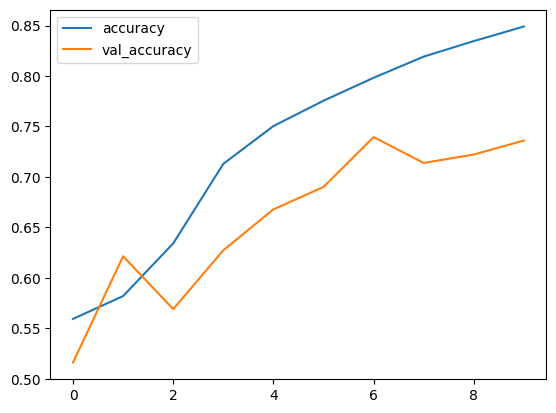

In [10]:
history[['accuracy','val_accuracy']].plot(kind='line')

In [11]:
tf.keras.backend.clear_session()